In [1]:
import sys
sys.path.insert(0, '../..')

# general
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set()
warnings.filterwarnings("ignore")

# local
from sklearn_crfsuite import metrics
from core.stats import Statistics
from core.utils import load_dataset, format_number
from core.plots import plot_histogram, plot_learning_curve
from core.learning import LearningAnalyser
from core.reports import (
    compute_user_error,
    generate_comparison_report,
    generate_test_groups_comparison_report,
    generate_learning_report
)
from core.dataset import DatasetAnalyser, DatasetGroup

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

from core.latex import create_latex_tables_generator

import numpy as np
np.random.seed(3453562)

# 1. General statistics
## 1.1. Read data

In [2]:
df = load_dataset('../../data/ebay_items_weight/ebay_items_weight-dataset.csv')

## 1.2. Statistics

In [3]:
stats = Statistics(df)

### 1.2.1. General

In [4]:
stats.general

,value
metric,
total_annotations,9387
unique_items,1017
unique_users,178
total_annotation_time,07h 45m 51s


### 1.2.2. Annotations per item

In [5]:
stats.annotations_per_item

,data__item_id
count,1017.000000
mean,9.230088
std,11.707061
min,2.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,181.000000


### 1.2.3. Annotations per user

In [6]:
stats.annotations_per_user

,user__id
count,178.000000
mean,52.735955
std,50.187816
min,11.000000
25%,50.000000
50%,50.000000
75%,50.000000
max,650.000000


### 1.2.4. Average annotation time over time

,value
index,
10,13.832898
20,11.905489
30,12.890960
40,11.556645
60,10.419404
70,8.714276
80,13.380433
90,8.751830


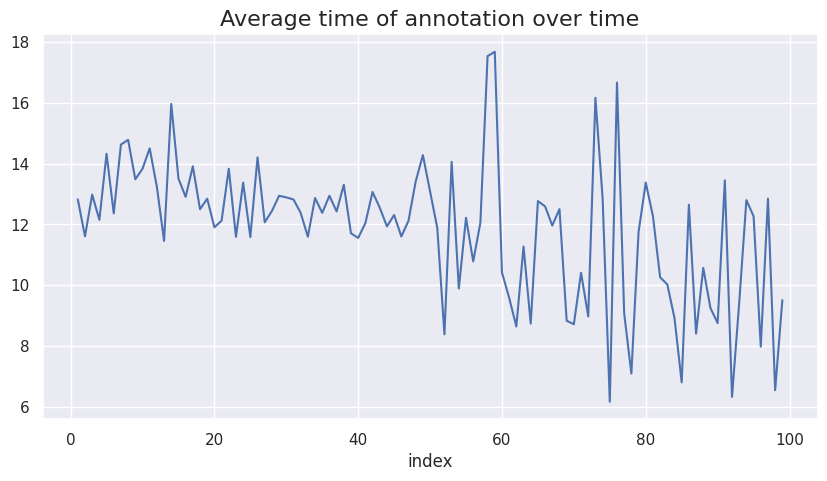

In [7]:
plt.figure(figsize=(10, 5))
plt.title("Average time of annotation over time", fontsize=16)
df_times = stats.average_time_per_annotation
df_times['value'].plot()
df_times[df_times.index % 10 == 0]

# 2. Confidence intervals
## 2.1. Compute user's annotation quality metrics
- In this section we aggregate the raw result to compute the quality metrics value per user
- To measure the quality of user's annotation we use: accuracy, recall, f1 and precision metrics
- Mean error is computed for each user in each test_group separately.<br/>
This way we can check how each user did in each test conditions

In [8]:
METRICS_COLUMNS = ["me", "mae", "mse", "annotation_time", "count"]

In [9]:
def metrics_function(y_true: pd.Series, y_pred: pd.Series):
    return {
        "mae": (y_true - y_pred).abs().mean(),
        "mse": (y_true - y_pred).pow(2).mean(),
        "me": (y_true - y_pred).mean()
    }
  
    
df_user_error = compute_user_error(df, metrics_function)

## 2.2. Compute confidence intervals for test groups
In this section we compute the confidence intervals for the percentage quality change between the control group and each of the test groups.

In [10]:
dataset = DatasetAnalyser(df_user_error, METRICS_COLUMNS)

### 2.2.1. Compering: test groups vs control group

In [11]:
df_ci_h1, df_percentage_ci_h1, df_p_value_h1, df_cohen_d_h1 = generate_comparison_report(dataset)

#### Confidence intervals

In [12]:
df_ci_h1

me         mae           mse  \
group_name              quantile                                         
high quality feedback   0.05     -590.562761 -197.273063 -1.627416e+06   
                        0.5      -466.049544 -123.583201 -9.710294e+05   
                        0.95     -333.115109  -45.594974 -3.211465e+05   
low quality feedback    0.05     -544.971504 -125.806185 -9.518621e+05   
                        0.5      -322.069247    3.703465 -1.847880e+04   
                        0.95      -95.143790  129.163331  8.572355e+05   
medium quality feedback 0.05      -57.266084 -244.538153 -1.604777e+06   
                        0.5       101.277914  -87.784009 -5.487887e+05   
                        0.95      270.025367   57.079435  4.014584e+05   

                                  annotation_time      count  
group_name              quantile                              
high quality feedback   0.05            -4.421713  -2.677317  
                        0.5             -1.969176   3.679581  
                        0.95             0.605754  10.369873  
low quality feedback    0.05             0.453339 -10.803922  
                        0.5              4.267262  -4.049281  
                        0.95             8.205376   2.918301  
medium quality feedback 0.05            -2.340280  -0.375758  
                        0.5              1.342257  25.228545  
                        0.95             5.080040  65.272727

#### Percentage confidence intervals

In [13]:
df_percentage_ci_h1

me       mae       mse  \
group_name              quantile                                 
high quality feedback   0.05     -0.787591 -0.194026 -0.425974   
                        0.5      -0.621537 -0.121549 -0.254166   
                        0.95     -0.444252 -0.044844 -0.084060   
low quality feedback    0.05     -2.840403 -0.112994 -0.239988   
                        0.5      -1.678632  0.003326 -0.004659   
                        0.95     -0.495891  0.116010  0.216130   
medium quality feedback 0.05      1.209988 -0.243747 -0.453749   
                        0.5      -2.139923 -0.087500 -0.155169   
                        0.95     -5.705425  0.056895  0.113512   

                                  annotation_time     count  
group_name              quantile                             
high quality feedback   0.05            -0.327123 -0.055502  
                        0.5             -0.145682  0.076280  
                        0.95             0.044814  0.214973  
low quality feedback    0.05             0.034428 -0.238838  
                        0.5              0.324065 -0.089516  
                        0.95             0.623135  0.064514  
medium quality feedback 0.05            -0.175995 -0.008350  
                        0.5              0.100941  0.560634  
                        0.95             0.382031  1.450505

#### p-value

In [14]:
df_p_value_h1

,me,mae,mse,annotation_time,count,group_name
0,0.0000,0.0045,0.0050,0.1017,0.8264,high quality feedback
0,0.0115,0.5254,0.4970,0.9676,0.1649,low quality feedback
0,0.8524,0.1850,0.1869,0.7240,0.9397,medium quality feedback


#### Cohen's D

In [15]:
df_cohen_d_h1

,me,mae,mse,annotation_time,count,group_name
0,-1.092842,-0.476265,-0.444544,-0.264038,0.186825,high quality feedback
0,-0.754419,0.014461,-0.009986,0.544506,-0.283981,low quality feedback
0,0.351252,-0.357770,-0.346063,0.185382,0.300753,medium quality feedback


#### Ploting histograms for the difference: test groups vs control group

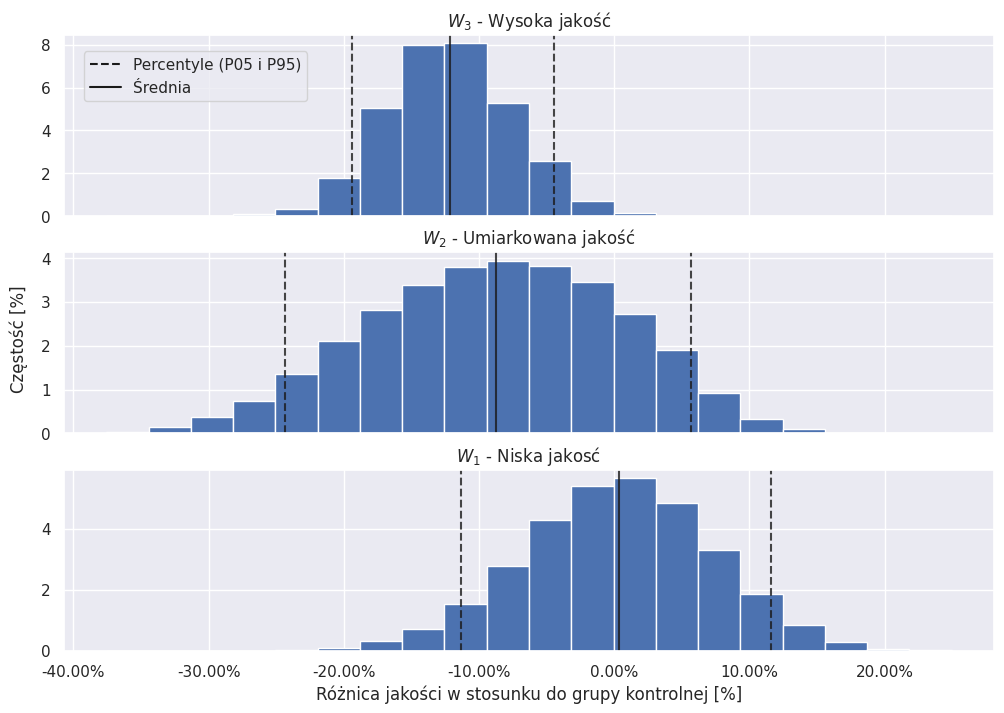

In [16]:
metric_index = 1
plot_histogram(dataset, metric_index)

### 2.2.2. Comparing: test groups with each other

In [17]:
df_ci_h2, df_p_value_h2, df_cohen_d_h2 = generate_test_groups_comparison_report(dataset)

#### Confidence interval

In [18]:
df_ci_h2

me       mae       mse  annotation_time     count
group_name  quantile                                                         
high_low    0.05     -0.132689 -0.271290 -0.551339        -0.814565 -0.028389
            0.5       1.057095 -0.124875 -0.249507        -0.469747  0.165796
            0.95      2.200039  0.007479  0.032550        -0.129619  0.369784
high_medium 0.05     -1.847603 -0.207096 -0.442052        -0.612185 -1.401397
            0.5       1.518386 -0.034049 -0.098996        -0.246623 -0.484355
            0.95      5.090741  0.139980  0.259264         0.090498  0.114290
medium_low  0.05     -4.298578 -0.273309 -0.516554        -0.636555  0.050437
            0.5      -0.461291 -0.090826 -0.150510        -0.223124  0.650150
            0.95      3.137276  0.090400  0.200894         0.189582  1.507717

#### p-value

In [19]:
df_p_value_h2

,me,mae,mse,annotation_time,count,group_name
0,0.9269,0.0614,0.0744,0.0151,0.9191,high_low
0,0.7660,0.3820,0.3204,0.1224,0.1581,high_medium
0,0.4305,0.2084,0.2447,0.1876,0.9737,medium_low


#### Cohen's D

In [20]:
df_cohen_d_h2

,me,mae,mse,annotation_time,count,group_name
0,2.080108,-2.118333,-2.021488,-3.155441,1.914417,high_low
0,1.021242,-0.468722,-0.701899,-1.702427,-1.384177,high_medium
0,-0.294236,-1.112952,-0.965953,-1.281597,1.851392,medium_low


# 3. Analyse learning curve

In [21]:
df['annotation_eval'] = (df['reference__output'] - df['annotation__output']).astype(int).abs()
df_high = df.query("test_group == 'high quality feedback'")

In [22]:
learning = LearningAnalyser(df_high)

#### Learning curve stats

In [23]:
learning_report = generate_learning_report(learning)
learning_report

,Metryka,Wartość
0,$\alpha$,0.342
1,$\beta$,-116.441
2,$\alpha_r$,+1.72%
3,$\beta_r$,-13.01%


#### Learning curve plot

In [24]:
# styling fix
learning_report['Wartość'] = learning_report['Wartość'].astype(str).str.replace(".", ",")

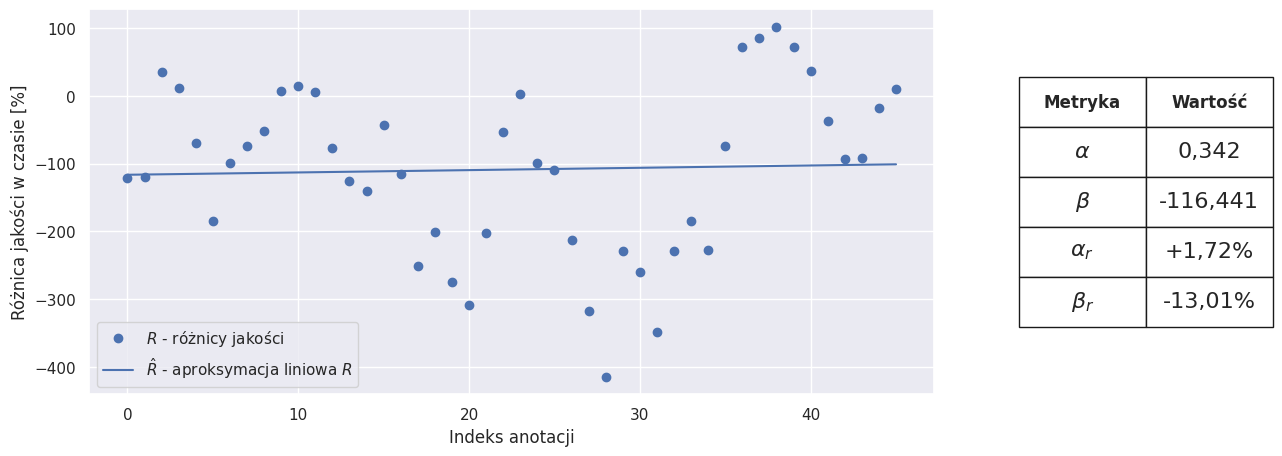

In [25]:
plot_learning_curve(learning, learning_report)

## Generate latex tables

In [26]:
latex_generator = create_latex_tables_generator(
    df_percentage_ci_h1=df_percentage_ci_h1,
    df_p_value_h1=df_p_value_h1,
    df_cohen_d_h1=df_cohen_d_h1,
    df_ci_h2=df_ci_h2,
    df_p_value_h2=df_p_value_h2,
    df_cohen_d_h2=df_cohen_d_h2
)

In [27]:
print(latex_generator.get_results_table("mae"))


\begin{table}[H]
\centering
\caption{}
\label{tab:my-table}
\begin{tabular}{cccccc}
\rowcolor[HTML]{EFEFEF} 
\multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\textbf{Warunek}} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{05}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$\mu$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$P_{95}$} &
  \multicolumn{1}{c|}{\cellcolor[HTML]{EFEFEF}\boldmath$p$} &
  \boldmath$d$ \\ \hline
\rowcolor[HTML]{EFEFEF} 
\multicolumn{6}{c}{\cellcolor[HTML]{EFEFEF}Hipoteza $H_1$ -- zmiana w metryce XXXX}                                                                                                        \\ \hline
        \multicolumn{1}{c|}{$W_1$} & \multicolumn{1}{c|}{-19.40\%} & \multicolumn{1}{c|}{-12.15\%} & \multicolumn{1}{c|}{-4.48\%} & \multicolumn{1}{c|}{0.0045} & -0.48 \\ \hline\multicolumn{1}{c|}{$W_2$} & \multicolumn{1}{c|}{-24.37\%} & \multicolumn{1}{c|}{-8.75\%} & \multicolumn{1}{c|}{+5.69\%} & \multicolumn{1}{c|}